In [ ]:
# This notebook is the result of running main.py on sva task

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
from transformers import AutoTokenizer
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
import itertools
from torch.serialization import add_safe_globals
from typing import NamedTuple, Iterable, Mapping, Sequence, Union

from setup_data.sparse_matrix import SparseMatrix
from setup_data.model_helpers import (
    load_model_and_saes, 
    model_run_activations, 
    evaluate_on_task, 
    get_latent_explanation,
)
from setup_data.data_helpers import load_data, process_data, tokenize_and_reshape, filter_prompts_by_label


class LatentRangeEntry(NamedTuple):
    latent_idx: int
    sae_name: str
    lb: float
    ub: float
    kl: float
    p_y: np.ndarray # P(Y=y | lb <= latent <= ub)
    p_range: np.ndarray # P(lb <= latent <= ub | Y=y)
    p_y_max: float
    p_range_max: float
    pred_class: int

def get_all_activations(model, saes, sae_names, prompt_dataset):
    """
    Returns a sparse version of all SAE activations of the last position over prompt_dataset forward passes.
    The full SAE activation can be retrieved via all_acts_train[sae_name].to_dense() of (n_samples, d_SAE)
    """
    all_acts_train = {sae_name: [] for sae_name in sae_names}
    for batch in tqdm(prompt_dataset, desc="Running model on dataset"):
        batch_acts = model_run_activations(model, saes, batch)
        for sae_name, sae_act in batch_acts.items():
            all_acts_train[sae_name].append(sae_act)
    for sae_name in all_acts_train:
        all_acts_train[sae_name] = SparseMatrix(torch.cat(all_acts_train[sae_name], dim=0))
    return all_acts_train

def build_important_latents(all_entries, sae_names, classes, score):
    '''
    entries: list of LatentRangeEntry for every single latent and range
    for every single latent

    Returns
    -------
    important_latents : dict[str, dict[int, list[tuple]]]
        SAE layer name ➜ {class_id: [(latent_idx, lb, ub), …], …}.
    '''

    important_latents = {}
    for s in sae_names:
        important_latents[s] = {}
        for c in classes:
            important_latents[s][c] = {} # when returning, this will be type list
            # ... bad coding practice

    for e in all_entries:
        s, c = e.sae_name, e.pred_class
        if e.p_range_max > 0.7 and e.p_y_max > 0.7:
            if e.latent_idx not in important_latents[s][c] or score(e) > score(important_latents[s][c][e.latent_idx]):
                important_latents[s][c][e.latent_idx] = e

    for s in sae_names:
        for c in classes:
            if not important_latents[s][c]:
                important_latents[s][c] = [(0, -5, -5)]
            else:
                important_latents[s][c] = [(e.latent_idx, e.lb, e.ub) for e in important_latents[s][c].values()]

    return important_latents

def get_important_training_activations(
        all_acts_train, 
        important_latent_idx_ranges, 
        label_dataset,
        groups=None
):
    """
    Parameters
    ----------
    all_acts_train : dict[str, torch.Tensor (n_samples, d_SAE)] see get_all_activations
    important_important_latent_idx_rangeslatent_idxs : dict[str, dict[str, list[tuple]]]
        SAE layer name ➜ {class_id: [(latent_idx, lb, ub), …], …}.
        Only the first element (latent_idx) is used here; lb/ub are ignored.

    Returns
    -------
    dict[str, dict[str, torch.Tensor]]
        SAE layer name ➜ {class_id: (n_samples, d_SAE_nnz)} comprsesed SAE activations such that
        important_training_acts_{s,c}[:,i] of (n_samples,) is the latent activations for important_latents_{s,c}[i]
    """
    important_training_acts = {}
    for s in important_latent_idx_ranges:
        important_training_acts[s] = {}
        for c in important_latent_idx_ranges[s]:
            prompt_idx_target = filter_prompts_by_label(groups[c], label_dataset, include_not_target=False).unsqueeze(1)
            idxs = torch.tensor([tup[0] for tup in important_latent_idx_ranges[s][c]])
            tmp = all_acts_train[s].to_dense()
            important_training_acts[s][c] = tmp[prompt_idx_target, idxs]
            del tmp
    return important_training_acts
# # %%
def scoring_all_ranges(
    latent_idx: int,
    sae_name: str,
    neuron_vals: np.ndarray,
    labels: Sequence[str],
    criteria=None,
    nbins: int = 100,
    min_samples: int = 10,
    label_groups: Union[Mapping[str, Iterable[str]],
                        Iterable[Iterable[str]], None] = None,
):
    """
    Parameters
    ----------
    label_groups
        • If None (default) behaviour is identical to the original function  
        • If a *dict*  -> {group_name: [label1, label2, ...]}  
        • If an *iterable of iterables*  -> [[label1, label2], [label3, …]]  
          (groups will be named 'g0', 'g1', …)  
        Any label not mentioned in `label_groups` is treated as its own singleton class.
    """
    # --------------------------------------------------------------------- #
    # 1. Map raw labels → group names
    # --------------------------------------------------------------------- #
    if label_groups is None:
        grouped_labels = np.asarray(labels)
    else:
        # build label → group_name dictionary
        if isinstance(label_groups, Mapping):
            groups_dict = {lab: gname for gname, labs in label_groups.items()
                                      for lab in labs}
        else:  # list/tuple/other iterable of iterables
            groups_dict = {lab: f"g{i}" for i, labs in enumerate(label_groups)
                                         for lab in labs}

        grouped_labels = np.array([groups_dict.get(lab, lab) for lab in labels])

    # --------------------------------------------------------------------- #
    # 2. Usual preprocessing but with *group* labels
    # --------------------------------------------------------------------- #
    classes_tokens = np.unique(grouped_labels)
    total_counts   = np.bincount(grouped_labels,
                                 minlength=classes_tokens.size).astype(np.float32)

    data      = []
    linspace  = np.linspace(neuron_vals.min(), neuron_vals.max(), nbins)

    # --------------------------------------------------------------------- #
    # 3. Sweep over (lb, ub) ranges as before
    # --------------------------------------------------------------------- #
    for i, lb in enumerate(linspace):
        for ub in linspace[i + 1:]:
            in_range = (neuron_vals >= lb) & (neuron_vals <= ub)
            range_lbls = grouped_labels[in_range]
            if range_lbls.size < min_samples:
                continue

            counts   = np.bincount(range_lbls,
                                   minlength=classes_tokens.size)
            p_y      = counts / counts.sum()
            p_range  = counts / total_counts
            kl       = np.sum(p_y[p_y > 0] * np.log(p_y[p_y > 0] *
                                                    len(classes_tokens)))

            entry = LatentRangeEntry(
                latent_idx=latent_idx,
                sae_name=sae_name,
                lb=lb,
                ub=ub,
                kl=kl,
                p_y=p_y.copy(),
                p_range=p_range.copy(),
                p_y_max=p_y.max(),
                p_range_max=p_range.max(),
                pred_class=classes_tokens[p_y.argmax()],
            )
            if entry.kl > 0.1 and entry.p_y_max > 0.1 and entry.p_range_max > 0.1:
                data.append(entry)
    return data
# # %%

def scoring_all_ranges_fast(
    latent_idx: int,
    sae_name: str,
    neuron_vals: np.ndarray,
    labels: Sequence[str],
    criteria=None,
    nbins: int = 10,
    min_samples: int = 10,
    label_groups: Union[Mapping[str, Iterable[str]],
                        Iterable[Iterable[str]], None] = None,
):
    """
    Vectorised implementation (PyTorch) —
    all O(nbins²) (lb, ub) combinations are scored in parallel.

    The public doc‑string is unchanged; see original for details.
    """

    # ------------------------------------------------------------------ #
    # 1. Map raw labels → group names  (unchanged, still NumPy/pythonic) #
    # ------------------------------------------------------------------ #
    if label_groups is None:
        grouped_labels = np.asarray(labels)
    else:
        if isinstance(label_groups, Mapping):
            groups_dict = {lab: gname for gname, labs in label_groups.items()
                                      for lab in labs}
        else:
            groups_dict = {lab: f"g{i}" for i, labs in enumerate(label_groups)
                                         for lab in labs}
        grouped_labels = np.array([groups_dict.get(lab, lab) for lab in labels])

    # ------------------------------------------------------------------ #
    # 2. Encode classes to integer IDs (→ torch)                         #
    # ------------------------------------------------------------------ #
    classes_tokens, inv = np.unique(grouped_labels, return_inverse=True)
    y      = torch.from_numpy(inv).long()         # (N,)
    x      = (neuron_vals).float()

    n_cls  = classes_tokens.size
    N      = x.size(0)

    # total counts per class for p_range
    total_counts = torch.bincount(y, minlength=n_cls).float()   # (C,)

    # ------------------------------------------------------------------ #
    # 3. Sort once → prefix‑sums                                         #
    # ------------------------------------------------------------------ #
    sort_idx      = torch.argsort(x)
    x_sorted      = x[sort_idx]                    # (N,)
    y_sorted      = y[sort_idx]                    # (N,)

    # one‑hot → cumulative counts  (shape: C × (N+1))
    cum = torch.zeros(n_cls, N + 1, dtype=torch.int32)
    cum[ y_sorted, torch.arange(N) + 1 ] = 1       # scatter one‑hot
    cum = cum.cumsum(dim=1)                        # prefix sums along samples

    # ------------------------------------------------------------------ #
    # 4. Discretise the value range & pre‑compute sample indices          #
    # ------------------------------------------------------------------ #
    edges          = torch.linspace(x.min(), x.max(), nbins)
    lower_pos      = torch.searchsorted(x_sorted, edges, right=False)  # idx of first ≥ edge
    upper_pos      = torch.searchsorted(x_sorted, edges, right=True)   # idx of first  > edge

    # create all (i < j) combinations with torch.triu_indices
    tri            = torch.triu_indices(nbins, nbins, offset=1)
    lb_ids, ub_ids = tri[0], tri[1]               # (K,) each, K = nbins*(nbins-1)/2

    # prefix‑sum slice:  counts_in_range = cum[:, ub_pos] - cum[:, lb_pos]
    counts_in_lb   = cum[:, lower_pos[lb_ids]]    # (C, K)
    counts_in_ub   = cum[:, upper_pos[ub_ids]]    # (C, K)
    counts         = (counts_in_ub - counts_in_lb).float()      # (C, K)

    # total samples per range
    n_in_range     = counts.sum(dim=0)            # (K,)

    # ------------------------------------------------------------------ #
    # 5. Probabilities & information metrics (all vectorised)            #
    # ------------------------------------------------------------------ #
    valid_mask     = n_in_range >= min_samples
    if not valid_mask.any():
        return []                                 # nothing passes min_samples

    counts         = counts[:, valid_mask]        # keep only candidate ranges
    n_in_range     = n_in_range[valid_mask]       # (K',)
    lb_ids         = lb_ids[valid_mask]
    ub_ids         = ub_ids[valid_mask]

    p_y            = counts / n_in_range          # (C, K')
    with torch.no_grad():                         # avoid log(0) warnings
        log_term   = torch.where(p_y > 0,
                                 torch.log(p_y * n_cls),
                                 torch.zeros_like(p_y))
    kl             = (p_y * log_term).sum(dim=0)  # (K',)

    p_range        = counts / total_counts.unsqueeze(1)          # (C, K')
    p_y_max        = p_y.max(dim=0).values
    p_range_max    = p_range.max(dim=0).values

    select_mask    = (kl > 0.1) & (p_y_max > 0.1) & (p_range_max > 0.1)

    if not select_mask.any():
        return []

    # ------------------------------------------------------------------ #
    # 6. Materialise the short‑listed ranges as LatentRangeEntry objects #
    # ------------------------------------------------------------------ #
    sel_idx        = torch.nonzero(select_mask, as_tuple=False).squeeze(1)
    pred_cls_idx   = p_y[:, sel_idx].argmax(dim=0)

    data = []
    for k, idx in enumerate(sel_idx.tolist()):
        entry = LatentRangeEntry(
            latent_idx=latent_idx,
            sae_name=sae_name,
            lb=edges[ lb_ids[idx] ].item(),
            ub=edges[ ub_ids[idx] ].item(),
            kl=kl[idx].item(),
            p_y=p_y[:, idx].cpu().numpy().copy(),
            p_range=p_range[:, idx].cpu().numpy().copy(),
            p_y_max=p_y_max[idx].item(),
            p_range_max=p_range_max[idx].item(),
            pred_class=classes_tokens[ pred_cls_idx[k] ],
        )
        data.append(entry)

    return data

/home/davidsc2/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# %%

def make_rules(
    important_latent_idx_ranges: dict[str, dict[str, list[tuple]]],
    important_training_acts: dict[str, dict[str, torch.Tensor]],
    k: int = 1,
) -> dict[str, dict[str, torch.Tensor]]:
    """
    Generate up to top-k rule patterns per class based on activation intervals.

    Args:
        important_latent_idx_ranges: mapping from layer to class to list of (latent_idx, lb, ub).
        important_training_acts: mapping from layer to class to activations tensor of shape (N, num_latents).
        k: number of top patterns (rules) to keep per class.

    Returns:
        rules_all_layers: mapping from layer to class to Tensor of shape (k, num_entries) containing boolean rule masks.
    """
    rules_all_layers: dict[str, dict[str, torch.Tensor]] = {}
    for layer, class_ranges in important_latent_idx_ranges.items():
        rules_all_layers[layer] = {}
        for cls, entries in class_ranges.items():
            device = important_training_acts[layer][cls].device
            latent_idxs = [tup[0] for tup in entries]
            map_idx_to_col = {latent_idx: col for col, latent_idx in enumerate(latent_idxs)}

            intervals = torch.tensor([[lb, ub] for (_, lb, ub) in entries], device=device)
            col_sel = torch.tensor([map_idx_to_col[i] for i in latent_idxs], dtype=torch.long, device=device)
            act_target = important_training_acts[layer][cls][:, col_sel]

            rule_mask = (act_target > intervals[:, 0]) & (act_target < intervals[:, 1])

            patterns, cnts = torch.unique(rule_mask, dim=0, return_counts=True)
            k_eff = min(k, cnts.size(0))
            topk_cnts, topk_idxs = torch.topk(cnts, k_eff, largest=True)
            topk_patterns = patterns[topk_idxs]

            rules_all_layers[layer][cls] = topk_patterns

    return rules_all_layers

def get_prediction(
    activation: torch.Tensor,
    rules_by_class: dict[str, torch.Tensor],
    sae_layer_for_rules: str,
    important_latent_idx_ranges: dict[str, dict[str, list[tuple]]],
) -> list:
    """
    Predict classes whose any of the top-k rules match the given activation.

    Args:
        activation: Tensor of activations for all latents at a given layer.
        rules_by_class: mapping from class to Tensor of shape (k, num_entries) of boolean masks.
        sae_layer_for_rules: the layer key to use in `important_latent_idx_ranges`.
        important_latent_idx_ranges: mapping from layer to class to entries for reconstructing active_set.
        prompt: (unused) original prompt.
        gt: (unused) ground truth label.

    Returns:
        List of classes c for which at least one rule matches.
    """
    layer = sae_layer_for_rules
    predictions = []
    for cls, patterns in rules_by_class.items():
        entries = important_latent_idx_ranges[layer][cls]
        active_set = torch.tensor([
            bool(lb < activation[idx].item() < ub)
            for (idx, lb, ub) in entries
        ], dtype=torch.bool)
        for rule_mask in patterns:
            # which is better: if torch.all(rule_mask == active_set)
            # or if torch.all(active_set[rule_mask])?
            if torch.all(rule_mask == active_set):
                predictions.append(cls)
                break
    return predictions

def apply_rule_mask_to_sets_with_ranges(
    rules_all_layers: dict[str, dict[str, torch.Tensor]],
    important_latent_idx_ranges: dict[str, dict[str, list[tuple[int, float, float]]]],
) -> dict[str, dict[str, list[list[tuple[int, tuple[float, float]]]]]]:
    """
    Converts rule masks to lists of (latent index, activation range) for each rule.

    Args:
        rules_all_layers: output of `make_rules`, maps layer -> class -> tensor of rule masks.
        important_latent_idx_ranges: maps layer -> class -> list of (latent_idx, lb, ub).

    Returns:
        rules_as_detailed: maps layer -> class -> list of rules, where each rule is a list of
                           (latent_idx, (lb, ub)) for active indices.
    """
    rules_as_detailed = {}
    for layer, class_rules in rules_all_layers.items():
        rules_as_detailed[layer] = {}
        for cls, rule_masks in class_rules.items():
            latent_info = important_latent_idx_ranges[layer][cls]  # List of (latent_idx, lb, ub)
            detailed_rules = []
            for rule_mask in rule_masks:
                active_features = []
                for active, (latent_idx, lb, ub) in zip(rule_mask.tolist(), latent_info):
                    if active:
                        active_features.append((int(latent_idx), (float(lb), float(ub))))
                detailed_rules.append(active_features)
            rules_as_detailed[layer][cls] = detailed_rules
    return rules_as_detailed

In [ ]:
# %%

def main():
    pass # so running this cell doesn't error in interactive mode

In [ ]:
    # %%

add_safe_globals([SparseMatrix])

hf_cache = "/home/davidsc2/"

on_delta = False
if on_delta:
    print("Not running in a Jupyter Notebook")
    hf_cache = "/u/dcheung2/content/hf_cache"

os.environ["HF_HOME"] = hf_cache
print(f"Using Hugging Face cache directory: {hf_cache}")

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using Hugging Face cache directory: /home/davidsc2/
Using device: cuda:0


In [ ]:
    # %% 

# INPUT PARAMS
model_name = "google/gemma-2-2b"
sae_layer_idx = 23

# for neuronpedia annotations
model_id = "gemma-2-2b"
expl_layer = f"{sae_layer_idx}-gemmascope-res-16k"

task = "sva"
if task == "sva":
    batch_size = 16
    max_samples_train = 6000
    max_samples_test = 1000
    acts_train_path = f'train_acts_sva_resid_{sae_layer_idx}_max_samples_{max_samples_train}.pt'
    acts_test_path = f'test_acts_sva_resid_{sae_layer_idx}_max_samples_{max_samples_test}.pt'
    file_path = "data/sva/rc_train.json"
    example_length = 7
    groups_plaintext = {
        0:     [' go',  ' are', ' do',  ' have'], # plural
        1:     [' goes', ' is', ' does', ' has'], # singular
    }
    topk_rules = 2
elif task == "key":
    batch_size = 16
    max_samples_train = 6000
    max_samples_test = 1000
    acts_train_path = f'train_acts_key_no_err_resid_{sae_layer_idx}_max_samples_{max_samples_train}.pt'
    acts_test_path = f'test_acts_key_no_err_resid_{sae_layer_idx}_max_samples_{max_samples_test}.pt'
    acts_train_path = f'all_training_activations_sva_resid_{sae_layer_idx}_max_samples_{max_samples_train}.pt'
    acts_train_path = f'all_training_activations_sva_resid_{sae_layer_idx}_max_samples_{max_samples_test}.pt'
    file_path = "data/codereason/key/data_len5_digit1.json"
    example_length = 41
    groups_plaintext = {
        0:     [ '1' ],
        1:     [ '2' ],
        2:     [ '3' ],
        3:     [ '4' ],
        4:     [ '5' ],
        5:     [ '6' ],
        6:     [ '7' ],
        7:     [ '8' ],
        8:     [ '9' ]
    }
    topk_rules = 1

In [ ]:
    # %%

if not (os.path.exists(acts_train_path) and os.path.exists(acts_test_path)):
    model, saes = load_model_and_saes(model_name, [sae_layer_idx], device, hf_cache)
else:
    print("Not loading model and saes, using precomputed activations")
    model, saes = None, None
tokenizer = AutoTokenizer.from_pretrained(model_name)

------------ Loading Model ------------
Loading model: google/gemma-2-2b...


Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 11.11it/s]


Loaded pretrained model google/gemma-2-2b into HookedTransformer
Model loaded and parameters frozen.


In [ ]:
    # %% prepare and process data

data = load_data(file_path)
assert data is not None
print("First Entry:", data[0] if isinstance(data, list) else data)

clean_prompts, corr_prompts, clean_labels, corr_labels = process_data(tokenizer, data, example_length)

clean_label_tokens = tokenizer(clean_labels[:max_samples_train], return_tensors="pt", add_special_tokens=False)["input_ids"].squeeze(-1)
corr_label_tokens = tokenizer(corr_labels[:max_samples_train], return_tensors="pt", add_special_tokens=False)["input_ids"].squeeze(-1)

include_corr_tokens = True
if include_corr_tokens:
    label_dataset = torch.cat((clean_label_tokens, corr_label_tokens), dim=0)
else:
    label_dataset = clean_label_tokens

def first_token_id(t):
    return tokenizer.encode(t, add_special_tokens=False)[0]

groups = {
    key: [first_token_id(value) for value in values]
    for key, values in groups_plaintext.items()
}
classes = list(groups.keys())

Loaded Data from: data/sva/rc_train.json
First Entry: {'clean_prefix': 'The friends that the dancer visits', 'patch_prefix': 'The friend that the dancer visits', 'clean_answer': ' go', 'patch_answer': ' goes', 'case': 'plural_singular'}
Number of filtered entries: 100731


In [ ]:
    # %%

# sae_names = [sae.cfg.hook_name for sae in saes]
sae_names = [f'blocks.{sae_layer_idx}.hook_resid_post']
if os.path.exists(acts_train_path):
    all_acts_train = torch.load(acts_train_path)
else:
    clean_prompt_tokens, corr_prompt_tokens, clean_label_tokens, corr_label_tokens = tokenize_and_reshape(
        model, 
        clean_prompts, corr_prompts, clean_labels, corr_labels, 
        batch_size=batch_size, max_samples=max_samples_train
    )
    if include_corr_tokens:
        prompt_dataset = torch.cat((clean_prompt_tokens, corr_prompt_tokens), dim=0)
    else:
        prompt_dataset = clean_prompt_tokens
    all_acts_train = get_all_activations(model, saes, sae_names, prompt_dataset)
    torch.save(all_acts_train, acts_train_path)
    print("training activations saved to ", acts_train_path)

nbins = 10               # Number of candidate bins for activation intervals
min_samples = 10         # Minimal examples needed for a valid interval

label_dataset_flat_np = label_dataset.view(-1).cpu().numpy()

Reshaped token shapes: torch.Size([375, 16, 7]) torch.Size([375, 16, 7]) torch.Size([375, 16]) torch.Size([375, 16])


Running model on dataset: 100%|██████████| 750/750 [02:08<00:00,  5.85it/s]


training activations saved to  train_acts_sva_resid_23_max_samples_6000.pt


In [ ]:
    # %%

entries = []

for sae_name in sae_names:
    # pull your dense tensor into CPU-memory and (optionally) numpy for pickling
    dense_acts = all_acts_train[sae_name].to_dense().cpu().numpy()
    active_mask = (dense_acts > 0).any(axis=0)
    active_indices = list(active_mask.nonzero()[0])
    print(f"Layer {sae_name}: {len(active_indices)} out of {dense_acts.shape[1]} neurons are active (> 0) at least once.")

    # define the per-neuron work
    def _score_neuron(i):
        # grab the i-th column back into a torch Tensor if your scorer expects one
        neuron_vals = torch.from_numpy(dense_acts[:, i])
        return scoring_all_ranges(
            i,
            sae_name,
            neuron_vals,
            label_dataset_flat_np,
            criteria=lambda entry: entry.kl > 0.1
                                    and entry.p_y_max > 0.1
                                    and entry.p_range_max > 0.1,
            nbins=nbins,
            min_samples=min_samples,
            label_groups=groups
        )

    # process in parallel, showing a tqdm bar
    # max_workers defaults to os.cpu_count(), but you can override if desired
    results = process_map(
        _score_neuron,
        active_indices,
        desc=f"Processing {sae_name} neurons",
        max_workers=None,   # or set to e.g. 8
        chunksize=1
    )

    # flatten and extend your entries list
    entries.extend(itertools.chain.from_iterable(results))

    del dense_acts


print(len(entries))

Layer blocks.23.hook_resid_post: 2338 out of 16384 neurons are active (> 0) at least once.


Processing blocks.23.hook_resid_post neurons: 100%|██████████| 2338/2338 [00:05<00:00, 397.94it/s]


476


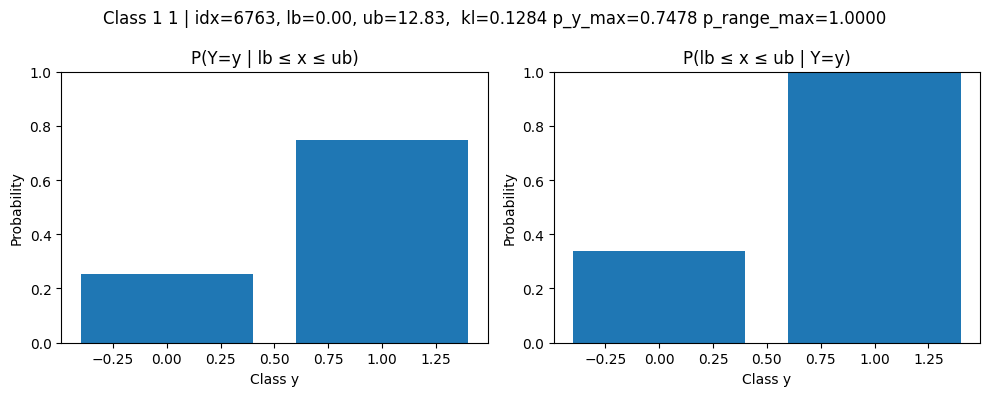

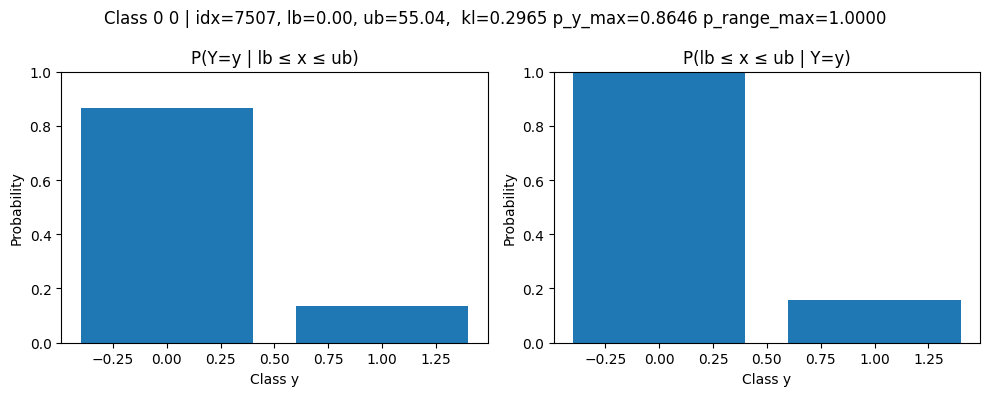

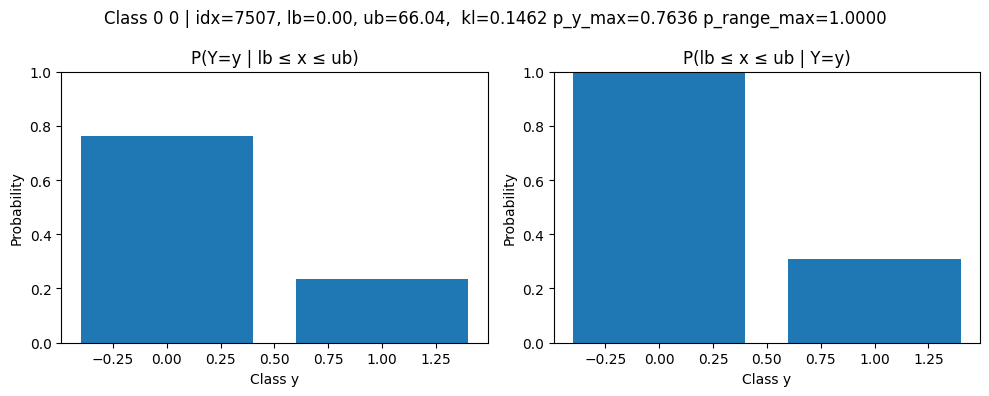

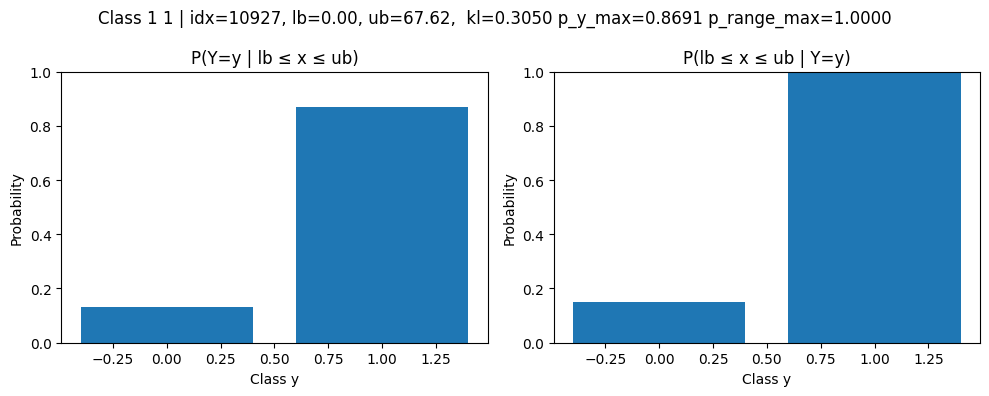

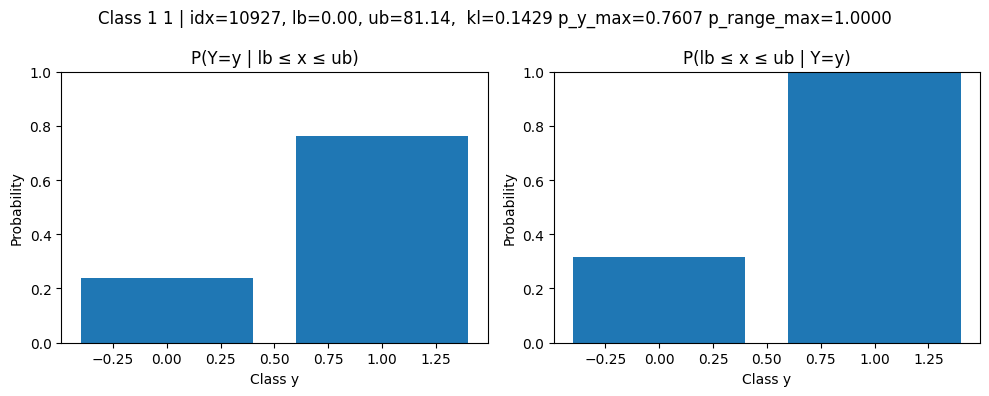

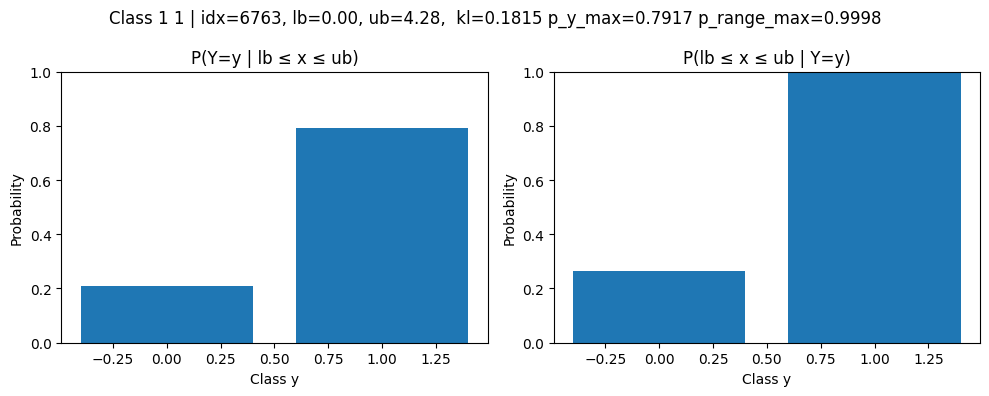

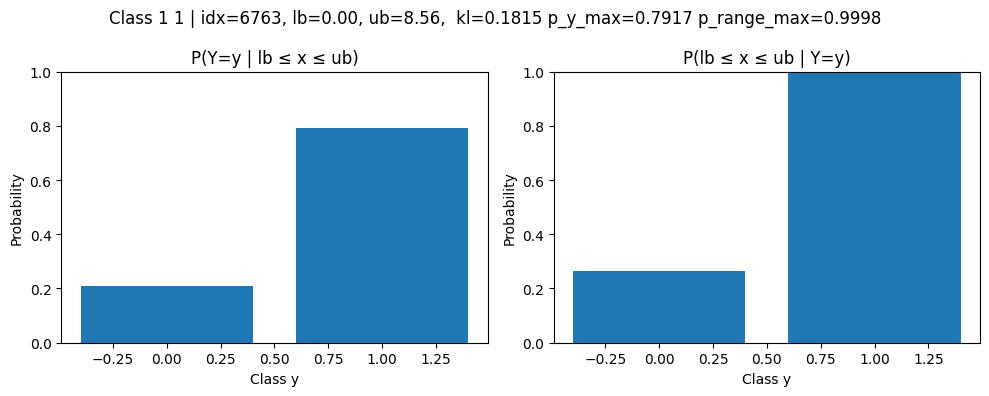

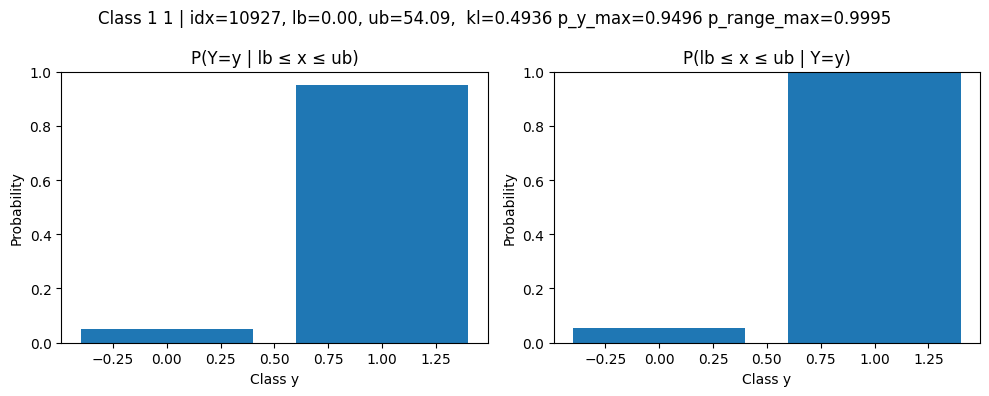

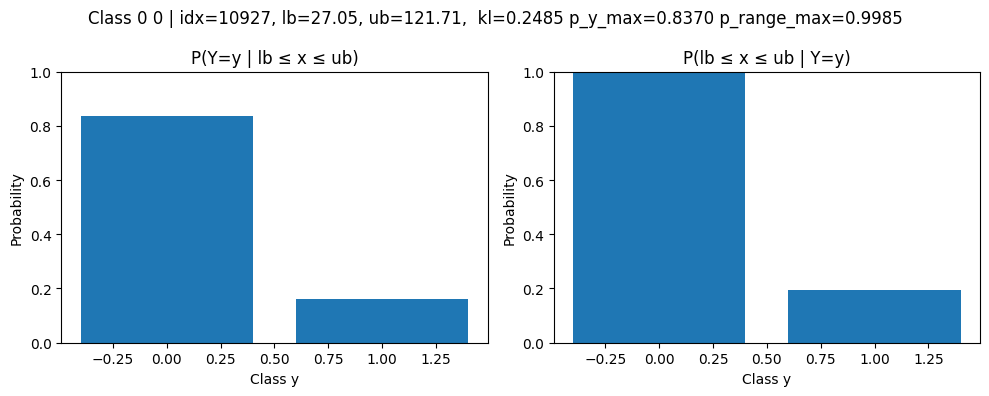

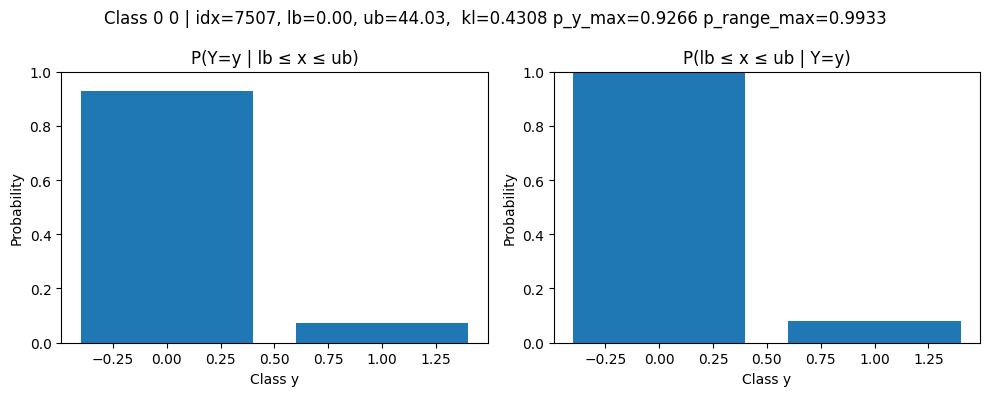

In [ ]:
    # %%

# latent activation statistics
i = 0
entries.sort(key=lambda x: -x.p_range_max)
for entry in entries:
    class_tokenized = entry.pred_class
    # class_cleantext = tokenizer.decode(torch.tensor(entry.pred_class))
    if entry.p_y_max > 0.7 and entry.p_range_max > 0.7:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        fig.suptitle(
            f"Class {class_tokenized} {class_tokenized} | "
            f"idx={entry.latent_idx}, lb={entry.lb:.2f}, ub={entry.ub:.2f}, "
            f" kl={entry.kl:.4f}"
            f" p_y_max={entry.p_y_max:.4f}"
            f" p_range_max={entry.p_range_max:.4f}"
        )

        # P(Y=y | lb ≤ x ≤ ub)
        axes[0].bar(range(len(entry.p_y)), entry.p_y)
        axes[0].set_title('P(Y=y | lb ≤ x ≤ ub)')
        axes[0].set_xlabel('Class y')
        axes[0].set_ylabel('Probability')
        axes[0].set_ylim(0, 1.0)

        # P(lb ≤ x ≤ ub | Y=y)
        axes[1].bar(range(len(entry.p_range)), entry.p_range)
        axes[1].set_title('P(lb ≤ x ≤ ub | Y=y)')
        axes[1].set_xlabel('Class y')
        axes[1].set_ylabel('Probability')
        axes[1].set_ylim(0, 1.0)

        plt.tight_layout()
        plt.show()
        i += 1
        if i == 10:
            break

In [ ]:
    # %%

important_latent_idx_ranges = build_important_latents(
    entries,
    sae_names,
    classes,
    score=lambda entry: (math.log(entry.p_y_max) + math.log(entry.p_range_max), -(entry.ub - entry.lb))
)

important_training_acts = get_important_training_activations(
    all_acts_train, 
    important_latent_idx_ranges,
    torch.from_numpy(label_dataset_flat_np),
    groups,
)

rules_by_class = make_rules(important_latent_idx_ranges, important_training_acts, k=topk_rules)

In [ ]:
    # %%

sae_layer_for_rules = f"blocks.{sae_layer_idx}.hook_resid_post"
batch_size = batch_size
num_examples_test = batch_size * 63
idx_test = slice(-num_examples_test, len(clean_labels), 1)
test_prompts = clean_prompts[idx_test]
test_labels = clean_labels[idx_test]

if os.path.exists(acts_test_path):
    all_acts_test = torch.load(acts_test_path, map_location="cpu")
else:
    all_acts_test = {}
    assert model is not None and saes is not None
    for start_idx in range(0, len(test_prompts), batch_size):
        batch_examples = test_prompts[start_idx : start_idx + batch_size]
        tokens = model.to_tokens(batch_examples)
        all_acts_test[start_idx] = model_run_activations(model, saes, tokens)
    torch.save(all_acts_test, acts_test_path)
    print("testing activations saved to ", acts_test_path)

print(f"---- Testing on {num_examples_test} Examples (batch_size={batch_size}) ----")

predictions = []
for start_idx in range(0, len(test_prompts)-batch_size, batch_size):
    activation_batch = all_acts_test[start_idx][sae_layer_for_rules]
    for i in range(batch_size):
        predictions.append(get_prediction(
            activation_batch[i], 
            rules_by_class[sae_layer_for_rules], 
            sae_layer_for_rules, 
            important_latent_idx_ranges,
        ))

precision = sum(
    1 for p, gt in zip(predictions, test_labels)
    if len(p) == 1 and gt in groups_plaintext[p[0]]
) / sum(1 for p in predictions if len(p) == 1)

abstain = sum(1 for p in predictions if len(p) != 1) / len(test_prompts)

print(f"Test Precision: {precision*100:.2f}%")
print(f"Test Abstain: {abstain*100:.2f}%")

testing activations saved to  test_acts_sva_resid_23_max_samples_1000.pt
---- Testing on 1008 Examples (batch_size=16) ----
Test Precision: 99.57%
Test Abstain: 5.65%


In [ ]:
    # %%

rules_as_sets = apply_rule_mask_to_sets_with_ranges(rules_by_class, important_latent_idx_ranges)
for layer, class_dict in rules_as_sets.items():
    print(f"\n=== Layer: {layer} ===")
    for cls, rules in class_dict.items():
        print(f"\nClass: {groups_plaintext[cls]}")
        for idx, rule in enumerate(rules):
            if not rule:
                print(f"  Rule {idx + 1}: [empty rule]")
                continue
            explanations = []
            for latent_idx, (lb, ub) in rule:
                # expl = get_latent_explanation(model_id, expl_layer, latent_idx)
                explanations.append(f"[{latent_idx}] ∈ ({lb:.3f}, {ub:.3f})")
            readable_rule = " AND ".join(explanations)
            print(f"  Rule {idx + 1}: {readable_rule}")


=== Layer: blocks.23.hook_resid_post ===

Class: [' go', ' are', ' do', ' have']
  Rule 1: [7507] ∈ (0.000, 44.030) AND [10927] ∈ (40.570, 121.709) AND [6763] ∈ (8.557, 38.505)
  Rule 2: [7507] ∈ (0.000, 44.030) AND [10927] ∈ (40.570, 121.709)

Class: [' goes', ' is', ' does', ' has']
  Rule 1: [10927] ∈ (0.000, 40.570) AND [7507] ∈ (44.030, 99.067)
  Rule 2: [7507] ∈ (44.030, 99.067)
